Counting programming language mentions in astronomy papers
==========================================================

"Q1 2019 Edition" Author: Juan Nunez-Iglesias.

Adapted from code [written by](https://nbviewer.jupyter.org/github/astrofrog/mining_acknowledgments/blob/master/Mining%20acknowledgments%20in%20ADS.ipynb)
[Thomas P. Robitaille](http://mpia.de/~robitaille/)
and
[updated by](https://nbviewer.jupyter.org/github/ChrisBeaumont/adass_proceedings/blob/master/Mining%20acknowledgments%20in%20ADS.ipynb)
[Chris Beaumont](https://chrisbeaumont.org/).

This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 3.0 Unported](http://creativecommons.org/licenses/by-nc-sa/3.0/deed.en_US) License.

![license](http://i.creativecommons.org/l/by-nc-sa/3.0/88x31.png)

### Changes since 2016

In April 2018, ADS [changed](http://adsabs.github.io/blog/updates) the default search behaviour to be metadata-only, so to get the original behaviour, I had to prepend 'full:' to the search query. Thanks to [Russell Anderson](https://www.monash.edu/science/schools/physics/about/ourpeople/anderson) and [Andy Casey](http://astrowizici.st/) for prompting me and helping me debug this. Andy in particular prompted me to add tqdm support, which makes the query step a lot nicer. =)

### The story so far

In 2014 I came across [this tweet](https://twitter.com/BeaumontChris/status/517412133181865984) by Chris Beaumont, showing Python overtaking Matlab and rapidly gaining ground on IDL in astronomy.

I'd referred to that plot a couple of times in the past, but [in 2016](https://github.com/jni/programming-languages-in-astronomy/blob/1991f7db48f7748492d3593fe6e142678cc951d1/programming-languages-in-ADS.ipynb) I wanted to use it in a PyCon-Au talk, so I thought it was time to update it. Hence, this notebook.

Jake VanderPlas updated the notebook [last year](https://mobile.twitter.com/__mharrison__/status/865612360886607872), showing an even more exilarating climb.

What does the story look like in March 2019? Well, it's not slowing down!

Overall, all three languages are climbing, reflecting the increased importance of computation in Astronomy. But Python's lead is widening dramatically.

First, let's import everything we need. You can install it all using either conda or pip.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, date
from tqdm import tqdm_notebook

Let's set some nice Matplotlib defaults. Note that there is a deprecation warning when setting the default color cycle, but I can't be bothered tracking down the fix. (It is not the simple replacement suggested by the deprecation message.)

In [2]:
mpl.rcParams['figure.figsize'] = (9,6)
mpl.rcParams['font.size'] = 14

Next, we import the [`ads` Python library](https://pypi.python.org/pypi/ads), which simplifies queries to the [Astrophysics Data System](https://ui.adsabs.harvard.edu). (The original notebooks used `requests` to create direct JSON queries, but the API appears to have changed in the meantime. I hope that using the `ads` library, someone else will take care of keeping the API queries up to date.)

To run this notebook, **you need to get a free API key** to allow queries to the ADS system. Create an account at [ADS](https://ui.adsabs.harvard.edu), log in, and then look for "Generate a new key" under your user profile.

Then, copy that key into a file called `.ads/dev_key` in your home directory. (You can also pass it as a string using the `token=<my_key>` keyword argument to `SearchQuery`, below)

In [3]:
import ads as ads

The ADS system has a daily limit to the number of queries you can perform with a given key (I think 5,000, as of this writing). So that you're not wasting queries while you're developing, you can use the `ads.sandbox` package that will return mock results to your queries. Uncomment the following cell to use the sandbox instead of the real API.

In [4]:
# Uncomment the following line to use the sandbox
# import ads.sandbox as ads

Next, we write a function that will count up how many results an individual query and year return, as well as a function to combine related queries (such as 'MATLAB' and 'Matlab').

In [5]:
def count_results(qstring):
    q = ads.SearchQuery(q=qstring)
    q.execute()
    return int(q.response.numFound)


def correct_partial_year(count, year):
    now = datetime.now().timetuple()
    if year == now.tm_year:
        days_in_year = date(year, 12, 31).timetuple().tm_yday
        corrected = count * days_in_year / now.tm_yday
        return corrected
    else:
        return count


def yearly_counts(query='', years=(2000, 2019)):
    """Count papers"""
    if type(query) == list:
        query = str.join(' OR ', query)
    results = []
    for year in tqdm_notebook(range(*years),
                              desc='years', leave=False):
        # the 'full:' modifier ensures full-text search
        mentions = count_results(f'full:({query}) year:{year} '
                                  'database:astronomy property:refereed')
        mentions_corrected = correct_partial_year(mentions, year)
        total = count_results(f'year:{year} database:astronomy '
                               'property:refereed')
        total_corrected = correct_partial_year(total, year)
        results.append([year, mentions_corrected, total_corrected])
    return np.array(results, dtype=float)

Finally, create a dictionary mapping languages to queries. I've left some of the original queries commented out, but you can uncomment them if you care about those languages in astronomy.

As a side note, a simple measure of how annoying a language's name is is given by the number of queries necessary to find its mentions.

In [6]:
# Use a regular dictionary since they are insertion-ordered since Py3.6
languages = {
    'IDL': ['IDL'],
    'Matlab': ['matlab'],  # lowercase -> case-insensitive
    'Python': ['python'],
    #'Fortran': ['fortran'],
    #'C': ['C programming language', 'C language',
    #      'C code', 'C library', 'C module'],
    #'R': ['R programming language', 'R language',
    #      'R code', 'R library', 'R module'],
}

The next cell runs the queries. Don't waste those API hits!

In [7]:
results = {name: yearly_counts(query)
           for name, query
           in tqdm_notebook(languages.items(), desc='languages')}

Finally, define a function to plot the results:

In [8]:
def trendlines(queries, norm=False):
    fig, ax = plt.subplots(figsize=(5, 5))
    for lang in languages:
        counts = queries[lang]
        x = counts[:, 0]
        y = np.copy(counts[:, 1])
        if norm:
            y /= counts[:, 2]
        ax.plot(x, y * 100, label=lang, lw=4, alpha=0.8)
    ax.set_xlim(np.min(x), np.max(x)+0.5)
    ax.set_xlabel('Year')
    ax.set_ylabel('Percent of Refereed\nPublications Mentioning')
    ax.legend(loc='upper left', frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

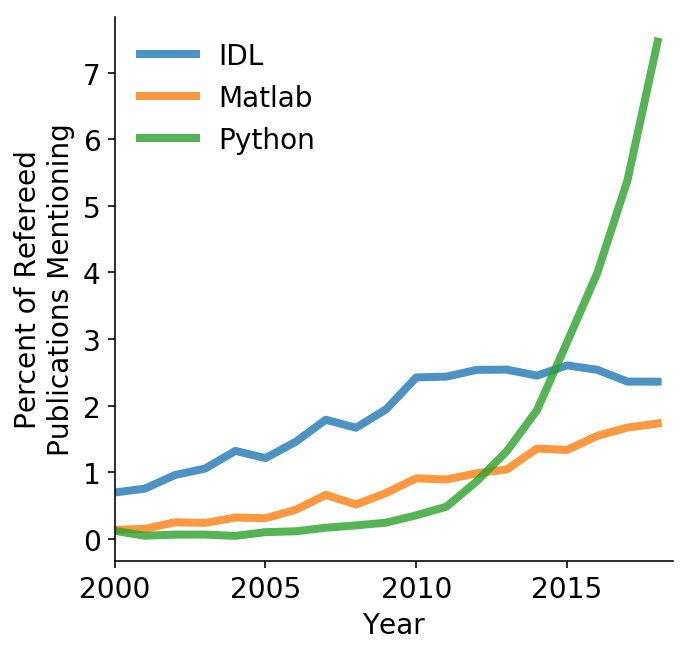

In [9]:
trendlines(results, norm=True)
plt.savefig('python-vs-matlab-vs-IDL-in-astro.pdf')

There you have it: some time in early 2015, Python overtook IDL as the most mentioned (and probably the most used) programming language in astronomy. Since then, the Python curve just keeps getting steeper!